# Imports

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn import metrics

import time
from contextlib import contextmanager
import gc
import warnings
import pprint
from IPython.display import clear_output

# Configuration

In [100]:
RANDOM_STATE= 190276
ROOT_INPUT = './data/work/'

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
sns.set()

# Fonctions

In [101]:
def scale(df: pd.DataFrame, robust = True) -> pd.DataFrame:
    
    if robust:
        scaler = preprocessing.RobustScaler()
    else:
        scaler = preprocessing.StandardScaler()
    columns = df.columns
    index = df.index
    df_scaled = scaler.fit_transform(df)
    
    df_scaled = pd.DataFrame(df_scaled, columns=columns, index=index)
    
    return df_scaled

# Model

In [102]:
def model_kmean(df, n_clusters, random_state = None, base_centers = None):
    
    # Selection des types number uniquement
    df_kmean = df.select_dtypes('number')
    
    # Robust scale
    df_scaled = scale(df_kmean)
    
    # Fit
    init = base_centers if (type(base_centers) == np.ndarray) else 'k-means++'
    n_init = 1 if (type(base_centers) == np.ndarray) else 10
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, init=init, n_init=1)
    kmeans.fit(df_scaled)
    
    return kmeans

# Load DataFrame

In [103]:
df = pd.read_pickle(ROOT_INPUT + 'rfm.pickle')
df = df.sort_values(by='order_purchase_timestamp_max', ascending=True)
df.reset_index(inplace=True)

In [104]:
df

,customer_unique_id,recence,frequence,montant,order_purchase_timestamp_max,order_period_year_max,order_period_quarter_max,order_period_month_max
0,b7d76e111c89f7ebf14761390f0f7d17,2551,0.0,72.89,2016-09-04 21:15:19,2016,2016Q3,2016-09
1,4854e9b3feff728c13ee5fc7d1547e92,2550,0.0,59.50,2016-09-05 00:15:34,2016,2016Q3,2016-09
2,0eb1ee9dba87f5b36b4613a65074337c,2523,0.0,100.00,2016-10-02 22:07:52,2016,2016Q4,2016-10
3,2f64e403852e6893ae37485d5fcacdaf,2522,0.0,21.90,2016-10-03 16:56:50,2016,2016Q4,2016-10
4,b8b8726af116a5cfb35b0315ecef9172,2522,0.0,21.50,2016-10-03 21:01:41,2016,2016Q4,2016-10
...,...,...,...,...,...,...,...,...
92953,9c3af16efacb7aa06aa3bc674556c5d6,1800,26.5,190.00,2018-09-25 11:59:18,2018,2018Q3,2018-09
92954,ba84da8c159659f116329563a0a981dd,1799,5.0,76.00,2018-09-26 08:40:15,2018,2018Q3,2018-09
92955,634420a0ea42302205032ed44ac7fccc,1794,23.0,65.00,2018-10-01 15:30:09,2018,2018Q4,2018-10
92956,af5454198a97379394cacf676e1e96cb,1792,9.0,178.00,2018-10-03 18:55:29,2018,2018Q4,2018-10


In [201]:
# Colonnes RFM
rfm = ['recence', 'frequence', 'montant']

# Recherche de la période optimale de reactualisation du model de clustering

Le principe est le suivant:

- Un clustering de base est réalisé sur 1 an de data
- On crée une boucle de calcul dans laquelle:
  - On ajoute un jour de data
  - on refait un clustering sur ce nouveau jeu de données elargie (en prenant garde d'utiliser les mêmes centroïds que le clustering de base afin de ne pas changer l'index des clusters)
  - on calcul l'evolution des clusters par rapport au clustering de base avec la metric Adjusted Rand Index
- On observe la courbe d'évolution journalière de l'ARI pour en déduire la période optimale de réactualisation du model

## Clustering avec 1 an de données


### Extraction du dataframe RFM de la 1ere année

In [213]:
base_days = 365

In [214]:
date_base_max = (pd.to_datetime(df['order_purchase_timestamp_max'].min()) + pd.Timedelta(unit='days', value=base_days)).round('d')
df_base = df.loc[df['order_purchase_timestamp_max'] < date_base_max, rfm]

In [215]:
df_base

,recence,frequence,montant
0,2551,0.0,72.89
1,2550,0.0,59.50
2,2523,0.0,100.00
3,2522,0.0,21.90
4,2522,0.0,21.50
...,...,...,...
21594,2186,0.0,59.90
21595,2186,0.0,179.90
21596,2186,0.0,59.90
21597,2186,0.0,339.90


### Clustering et recuperations des centroïds

In [216]:
model_base = model_kmean(df_base, 4, RANDOM_STATE)

In [217]:
base_centers = model_base.cluster_centers_

In [218]:
df_base['label'] = model_base.labels_

In [219]:
df_base

,recence,frequence,montant,label
0,2551,0.0,72.89,0
1,2550,0.0,59.50,0
2,2523,0.0,100.00,0
3,2522,0.0,21.90,0
4,2522,0.0,21.50,0
...,...,...,...,...
21594,2186,0.0,59.90,0
21595,2186,0.0,179.90,0
21596,2186,0.0,59.90,0
21597,2186,0.0,339.90,0


In [220]:
df_base['label'].value_counts()

label
0    20728
3      744
2       85
1       42
Name: count, dtype: int64

## Clustering incrémental

In [221]:
max_days = (pd.to_datetime(df['order_purchase_timestamp_max'].max()) - pd.to_datetime(df['order_purchase_timestamp_max'].min())).days

test_days = base_days + 1

ARS = []
while test_days <= max_days:
    date_test_max = (pd.to_datetime(df['order_purchase_timestamp_max'].min()) + pd.Timedelta(unit='days', value=test_days)).round('d')
    df_test = df.loc[df['order_purchase_timestamp_max'] < date_test_max, rfm]

    print(f'Calcul du l\'Adjusted Rand Score avec {test_days - base_days} jours de données supplémentaires à la base de travail', end='\r')
        
    model_test = model_kmean(df_test, 4, RANDOM_STATE, base_centers)
    new_labels = model_test.labels_[0:df_base.index.max()+1]
    ARS.append(metrics.adjusted_rand_score(df_base['label'].to_list(), new_labels))

    test_days = test_days + 1
        
print('')

Calcul du l'Adjusted Rand Score avec 406 jours de données supplémentaires à la base de travail


## Observation de l'evolution de l'ARI

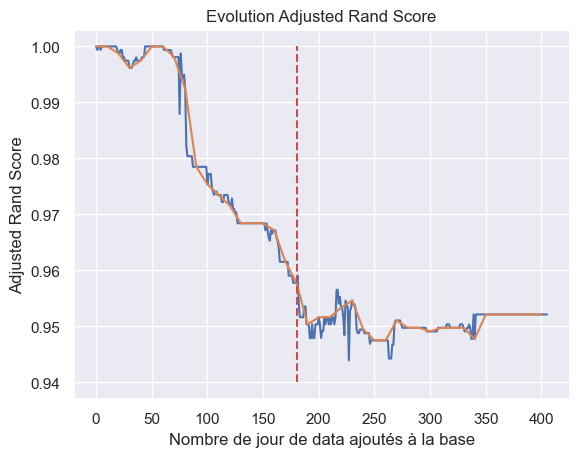

In [231]:
from scipy.interpolate import make_interp_spline

serie_ars = pd.Series(ARS)

X_Y_Spline = make_interp_spline(serie_ars.index, serie_ars.values)


serie_spline_index = np.arange(serie_ars.index.min(), serie_ars.index.max(), 10)
serie_spline=pd.Series(X_Y_Spline(serie_spline_index), index=serie_spline_index)

fig = plt.figure()

serie_ars.plot()
serie_spline.plot()

plt.vlines(180, 0.94,1, linestyles='dashed', color='r')
plt.title('Evolution Adjusted Rand Score')
plt.xlabel('Nombre de jour de data ajoutés à la base')
plt.ylabel('Adjusted Rand Score')
plt.show()

## Conclusion

A partir de 180 jours de données supplémentaires on atteint un palier pour lequel les clusters stagnent sur une évolution par rapport à leur état initial à 0.95 de l'Adjusted Rand Score.

La recommandation est donc de mettre le model à jour tous les 6 mois